In [1]:
import numpy as np
import pandas as pd
import glob
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

C:\Users\home-pc\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\home-pc\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# Чтение данных

In [2]:
reviews_train = []
label_train = []
for file in glob.glob('C:/Users/home-pc/Desktop/aclImdb/train/pos/*.txt'):
    if int(file[file.find('_')+1]) == 1 :
        label_train.append(10)
    else :
        label_train.append(int(file[file.find('_')+1]))
    f = open(file, encoding='utf-8')
    line = f.readline() 
    reviews_train.append(line)
    f.close()

In [3]:
for file in glob.glob('C:/Users/home-pc/Desktop/aclImdb/train/neg/*.txt'):
    label_train.append(int(file[file.find('_')+1]))
    f = open(file, encoding='utf-8')
    line = f.readline() 
    reviews_train.append(line)
    f.close()

In [4]:
reviews_test = []
label_test = []
for file in glob.glob('C:/Users/home-pc/Desktop/aclImdb/test/pos/*.txt'):
    if int(file[file.find('_')+1]) == 1 :
        label_test.append(10)
    else :
        label_test.append(int(file[file.find('_')+1]))
    f = open(file, encoding='utf-8')
    line = f.readline() 
    reviews_test.append(line)
    f.close()

In [5]:
for file in glob.glob('C:/Users/home-pc/Desktop/aclImdb/test/neg/*.txt'):
    label_test.append(int(file[file.find('_')+1]))
    f = open(file, encoding='utf-8')
    line = f.readline() 
    reviews_test.append(line)
    f.close()

In [6]:
df_train = pd.DataFrame({
 'review': reviews_train,
 'label': label_train
})

In [7]:
df_train.head()

,review,label
0,Bromwell High is a cartoon comedy. It ran at t...,9
1,Homelessness (or Houselessness as George Carli...,8
2,Brilliant over-acting by Lesley Ann Warren. Be...,10
3,This is easily the most underrated film inn th...,7
4,This is not the typical Mel Brooks film. It wa...,8


In [8]:
df_test = pd.DataFrame({
 'review': reviews_test,
 'label': label_test
})

# Подготовка данных

Предобработка текстов: разбиение по пробелам и знакам пунктуации; фильтрация не-слов, стоп-слов, коротких слов; приведение к нормальной форме.

In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

en_stop = list(stopwords.words('english'))
lemmatizer = WordNetLemmatizer() 

def tokenize(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [t for t in tokens if
              re.match(r'[^\W\d]*$', t) and (len(t) > 2) and (t not in en_stop)]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens

tokens_train = df_train['review'].apply(tokenize)

[nltk_data] Downloading package punkt to C:\Users\home-
[nltk_data]     pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\home-
[nltk_data]     pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\home-
[nltk_data]     pc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
tokens_test = df_test['review'].apply(tokenize)

# Обучение модели Word2Vec

С уже подобранными оптимальными параметрами

In [10]:
from gensim.models import Word2Vec

model = Word2Vec(tokens_train, size=300, window=5, min_count=2, iter=5, workers=10, sg=1, sample =1e-3)

# Векторное представление текста

Каждое слово в тексте представляем в виде вектора, дальше каждый текст заменяем на средний вектор

In [11]:
def encode(list_of_tokens):
    x = np.array([model.wv[t] for t in list_of_tokens if t in model.wv.vocab])
    return np.mean(x, axis=0)

features_train = np.array([encode(t) for t in tokens_train])
features_test = np.array([encode(t) for t in tokens_test])

# Модель классификации 

In [224]:
df_train['label'][df_train['label'].values<=4] = 0
df_train['label'][df_train['label'].values>=7] = 1
df_test['label'][df_test['label'].values<=4] = 0
df_test['label'][df_test['label'].values>=7] = 1

C:\Users\home-pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\home-pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\home-pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\home

In [13]:
xgb_model2 = xgb.XGBClassifier()
xgb_model2.fit(features_train, df_train['label'].values)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)

In [14]:
prediction_train = xgb_model2.predict(features_train)
prediction_test = xgb_model2.predict(features_test)

In [16]:
print(roc_auc_score(df_train['label'].values, prediction_train))
print(roc_auc_score(df_test['label'].values, prediction_test))

0.99692
0.83564


Можно добиться лучшей точности, для этого воспользуемся моделью doc2vec

# Обучение модели Doc2Vec

С уже подобранными оптимальными параметрами

In [10]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

texts = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokens_train)]
 
model1 = Doc2Vec(texts, vector_size=300, workers=10, epochs=25, window=5, hs=0, negative=15, min_count=1)

# Векторное представление текста

In [11]:
d2v_features_train = []
for x in texts:
    d2v_features_train.append(model1.infer_vector(x.words))

d2v_features_train = np.array(d2v_features_train)

In [12]:
d2v_features_test = []
for x in texts:
    d2v_features_test.append(model1.infer_vector(x.words))
d2v_features_test = np.array(d2v_features_test)

# Модель классификации 

In [59]:
xgb_model1 = xgb.XGBClassifier()
xgb_model1.fit(d2v_features_train, df_train['label'].values)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)

In [226]:
prediction_train = xgb_model1.predict(d2v_features_train)
prediction_test = xgb_model1.predict(d2v_features_test)

In [227]:
proba_train= xgb_model1.predict_proba(d2v_features_train)
proba_test = xgb_model1.predict_proba(d2v_features_test)

In [228]:
print('train ',accuracy_score(df_train['label'].values, prediction_train))
print('test ',accuracy_score(df_test['label'].values, prediction_test))

train  0.99844
test  0.94016


In [230]:
print('train ',roc_auc_score(df_train['label'].values, prediction_train))
print('test ',roc_auc_score(df_test['label'].values, prediction_test))

train  0.99844
test  0.94016


В силу однородности данных roc_auc совпадает с accuracy, так что в дальнейшем можем смотреть только на одну из эти двух метрик

In [64]:
print('Train\n', classification_report(df_train['label'].values, prediction_train))
print('Test\n', classification_report(df_test['label'].values, prediction_test))

Train
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12500
           1       1.00      1.00      1.00     12500

   micro avg       1.00      1.00      1.00     25000
   macro avg       1.00      1.00      1.00     25000
weighted avg       1.00      1.00      1.00     25000

Test
               precision    recall  f1-score   support

           0       0.94      0.94      0.94     12500
           1       0.94      0.94      0.94     12500

   micro avg       0.94      0.94      0.94     25000
   macro avg       0.94      0.94      0.94     25000
weighted avg       0.94      0.94      0.94     25000



In [77]:
for i in range(len(proba_train)):
    if proba_train[i][1] < 0.2:
        prediction_train[i] = 1
    if (proba_train[i][1] < 0.3) & (proba_train[i][1]>=0.2):
        prediction_train[i] = 2
    if (proba_train[i][1] < 0.4) & (proba_train[i][1]>=0.3):
        prediction_train[i] = 3
    if (proba_train[i][1] < 0.5) & (proba_train[i][1]>=0.4):
        prediction_train[i] = 4
    if (proba_train[i][1] < 0.6) & (proba_train[i][1]>=0.5):
        prediction_train[i] = 7
    if (proba_train[i][1] < 0.7) & (proba_train[i][1]>=0.6):
        prediction_train[i] = 8
    if (proba_train[i][1] < 0.8) & (proba_train[i][1]>=0.7):
        prediction_train[i] = 9
    if proba_train[i][1]>=0.8:
        prediction_train[i] = 10

In [78]:
for i in range(len(proba_test)):
    if proba_test[i][1] < 0.2:
        prediction_test[i] = 1
    if (proba_test[i][1] < 0.3) & (proba_test[i][1]>=0.2):
        prediction_test[i] = 2
    if (proba_test[i][1] < 0.4) & (proba_test[i][1]>=0.3):
        prediction_test[i] = 3
    if (proba_test[i][1] < 0.5) & (proba_test[i][1]>=0.4):
        prediction_test[i] = 4
    if (proba_test[i][1] < 0.6) & (proba_test[i][1]>=0.5):
        prediction_test[i] = 7
    if (proba_test[i][1] < 0.7) & (proba_test[i][1]>=0.6):
        prediction_test[i] = 8
    if (proba_test[i][1] < 0.8) & (proba_test[i][1]>=0.7):
        prediction_test[i] = 9
    if proba_train[i][1]>=0.8:
        prediction_test[i] = 10

In [67]:
df_train = pd.DataFrame({
 'review': reviews_train,
 'label': label_train
})
df_test = pd.DataFrame({
 'review': reviews_test,
 'label': label_test
})

In [79]:
print(accuracy_score(df_train['label'].values, prediction_train))
print(accuracy_score(df_test['label'].values, prediction_test))

0.38656
0.36204


In [220]:
#print(classification_report(df_train['label'].values, prediction_train))
#print(classification_report(df_test['label'].values, prediction_test))

# Отбор фичей 

In [31]:
# удаление фичей, которое почти не коррелированы с таргетом 
from math import fabs
from scipy.stats.stats import pearsonr
v=[] 
for i in range(d2v_features_train.shape[1]):
    if(fabs(pearsonr(d2v_features_train[:,i],df_train['label'].values)[0])>0.05):
        v.append(i)
print(len(v))

153


In [32]:
X = d2v_features_train[:,v]

In [33]:
xgb_model4 = xgb.XGBClassifier()
xgb_model4.fit(X, df_train['label'].values)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)

In [34]:
prediction_train = xgb_model4.predict(X)
prediction_test = xgb_model4.predict(d2v_features_test[:,v])

In [30]:
print(accuracy_score(df_train['label'].values, prediction_train))
print(accuracy_score(df_test['label'].values, prediction_test))

0.95584
0.86952


Сильно страдает качество, поэтому оставим все признаки

In [140]:
#функция для cross-validation
def modelfit(alg, X_train, Y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, Y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    print("the best number of n_estimators is ",cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, Y_train, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
        
    #Print model report:
    print ("Accuracy (Train): %.4g" % accuracy_score(Y_train.values, dtrain_predictions))
    print ("AUC Score (Train): %f" % roc_auc_score(Y_train, dtrain_predprob))                 

Попробуем пустить в ход нейронные сети

In [127]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical

Using TensorFlow backend.


In [184]:
model3 = Sequential([
    Dense(32, input_shape=(d2v_features_train.shape[1],), activation='relu'),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid'),
    
])

model3.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 32)                9632      
_________________________________________________________________
dense_53 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_54 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 129       
Total params: 20,193
Trainable params: 20,193
Non-trainable params: 0
_________________________________________________________________


In [185]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [132]:
df_train['label'][df_train['label'].values<=4] = 0
df_train['label'][df_train['label'].values>=7] = 1
df_test['label'][df_test['label'].values<=4] = 0
df_test['label'][df_test['label'].values>=7] = 1

C:\Users\home-pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\home-pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\home-pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\home

In [186]:
history = model3.fit(d2v_features_train, df_train['label'].values, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 69us/step - loss: 0.4661 - accuracy: 0.7653 - val_loss: 0.3574 - val_accuracy: 0.8494
Epoch 2/10
20000/20000 [==============================] - 1s 32us/step - loss: 0.3516 - accuracy: 0.8499 - val_loss: 0.5080 - val_accuracy: 0.7680
Epoch 3/10
20000/20000 [==============================] - 1s 31us/step - loss: 0.3324 - accuracy: 0.8581 - val_loss: 0.4481 - val_accuracy: 0.7996
Epoch 4/10
20000/20000 [==============================] - 1s 32us/step - loss: 0.3110 - accuracy: 0.8676 - val_loss: 0.4116 - val_accuracy: 0.8192
Epoch 5/10
20000/20000 [==============================] - 1s 33us/step - loss: 0.2892 - accuracy: 0.8796 - val_loss: 0.5072 - val_accuracy: 0.7712
Epoch 6/10
20000/20000 [==============================] - 1s 33us/step - loss: 0.2686 - accuracy: 0.8898 - val_loss: 0.4384 - val_accuracy: 0.8076
Epoch 7/10
20000/20000 [==============================] - 1s 37us/ste

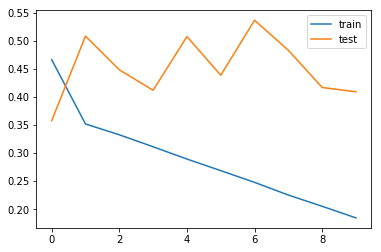

In [187]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

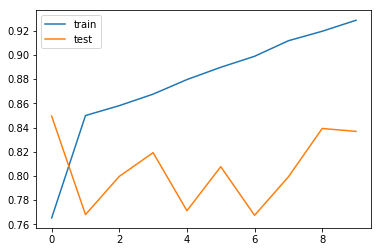

In [188]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [214]:
pred_train = model3.predict(d2v_features_train) > 0.34
print(classification_report(df_train['label'].values, pred_train))
pred_test = model3.predict(d2v_features_test) > 0.34
print(classification_report(df_test['label'].values, pred_test))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91     12500
           1       0.88      0.97      0.92     12500

   micro avg       0.92      0.92      0.92     25000
   macro avg       0.92      0.92      0.92     25000
weighted avg       0.92      0.92      0.92     25000

              precision    recall  f1-score   support

           0       0.94      0.85      0.90     12500
           1       0.87      0.95      0.91     12500

   micro avg       0.90      0.90      0.90     25000
   macro avg       0.91      0.90      0.90     25000
weighted avg       0.91      0.90      0.90     25000



In [215]:
print('train ', roc_auc_score(df_train['label'].values, model3.predict(d2v_features_train)))
print('test ', roc_auc_score(df_test['label'].values, model3.predict(d2v_features_test)))

train  0.9705111968000001
test  0.9646597760000001


Переобучения практически нет

# Сохраняем модели

In [222]:
import pickle 
with open('model_d2v.pickle', 'wb') as output:
    pickle.dump(model1, output)
    output.close

with open('model_clf.pickle', 'wb') as output:
    pickle.dump(xgb_model1, output)
    output.close